# Bonus1: Parallel Algorithms

### Name: Allison Aprile


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [118]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [119]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [120]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.00616917  0.09001558  0.07128022  0.05166182  0.15713509  0.17577619
   0.02937235  0.05300778]]
test std = 
[[1.12946259 1.07918954 1.02107922 0.96548112 1.1727157  0.94448239
  0.9679227  1.0243685 ]]


## 1.4. Add a dimension of all ones

In [121]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Implement Federated Averaging Learning

* Use 4 worker nodes
* Use GD and SGD (with batch size b=1)
* Set the number of local iterations to q=1 and 8
* Plot (training) objective function against epochs or number of communications. Note the difference between #epochs and #communications
* Note also that there are 4 lines in your plot (GD with q=1, GD with q=8, SGD with q=1, and SGD with q=8)

## 2.1 Define Worker and Server classes

In [122]:
import random

In [123]:
# Define worker class (using lecture notes)
# The i-th worker:
#    1. Receives model parameters w from the server
#    2. Repeats: a) Using w and its local data to compute g; b) Local w update
#    3. Sends w_i (local weight) to the server
class Worker:
    # Define/assign arguments
    def __init__(self, x, y, q):
        self.x = x   # Local feature matrix (s-by-d)
        self.y = y   # Local label matrix (s-by-1)
        self.s, self.d = x.shape   # Get samples and number of features
        self.w = np.zeros((d, 1))  # Model parameter vector (d-by-1)
        self.q = q # Number of repeats for local gradient updates
     
    # Set model parameters to the latest
    def set_param(self, w):
        self.w = w
        
    # Compute local loss
    def loss(self):
        yx = np.multiply(self.y, self.x) # (s-by-d)
        yxw = np.dot(yx, self.w) # (s-by-1)
        vec1 = np.exp(-yxw) # (s-by-1)
        vec2 = np.log(1 + vec1) # (s-by-1)
        return np.sum(vec2) # Loss function
    
    # **** Federal Averaging Repeat Step! ****
    # Compute local gradient and update w
    def local_gradient_and_update(self, alpha, alg='gd'):
        # Repeat computing local gradient and updating local w
        
        # Stochastic Gradient Descent
        if alg == 'sgd': 
            for r in range(q):
                for b in range(self.s):
                    # Sample one sample for update
                    ind = random.randrange(0, self.s)
                    sample_x = self.x[ind]
                    sample_y = self.y[ind]
                    
                    # Calculate gradient
                    yx = np.multiply(sample_y, sample_x) # (s-by-d)
                    yxw = np.dot(yx, self.w) # (s-by-1)
                    vec1 = np.exp(yxw) # (s-by-1)
                    vec2 = np.divide(yx, 1+vec1)
                    g = -np.sum(vec2, axis=0).reshape(self.d, 1) # (d-by-1)
            
                    # Update local w
                    self.w -= alpha * g
        
        # Gradient Descent
        else:
            for r in range(q):
                yx = np.multiply(self.y, self.x) # (s-by-d)
                yxw = np.dot(yx, self.w) # (s-by-1)
                vec1 = np.exp(yxw) # (s-by-1)
                vec2 = np.divide(yx, 1+vec1)
                g = -np.sum(vec2, axis=0).reshape(self.d, 1) # (d-by-1)

                # Update local w
                self.w -= alpha * g
                
        # Send w_i to server
        return self.w  

In [124]:
# Define server class (using lecture notes)
#    1. Receives all w_i from the m workers
#    2. Updates model parameters with an average
class Server:
    # Define/assign arguments
    def __init__(self, m, n, d):
        self.m = m  # Number of worker nodes
        self.n = n  # Number of training samples
        self.d = d  # Number of features
        self.w = np.zeros((d, 1)) # Model parameter vector (d-by-1)
        self.avg = np.zeros((d, 1)) # w_i average (d-by-1)
        self.loss = 0 # Loss function value
        self.obj = 0 # Objective function value
        
    # Broadcast w to the workers
    def broadcast(self):
        return self.w
    
    # **** Federal Averaging Step! ****
    # Average the weights and losses evaluated by the workers
    # Args:
    #    weights: a list of d-by-1 vectors
    #    losses: a list of scalars
    def average_workers(self, weights, losses):
        self.avg = np.zeros((self.d, 1)) # w_i avg (d-by-1)
        self.loss = 0  # Loss value
        
        # Sum weight values and losses of worker nodes
        for k in range(self.m):
            self.avg += weights[k]
            self.loss += losses[k]
    
        # Take average
        self.avg /= self.m
        self.loss /= self.m
        
    # Compute objective function (sum of loss) and regularization)
    def objective(self, lam):
        # Compute regularization term
        reg = lam / 2 * np.sum(self.w * self.w)
        self.obj = self.loss / self.n + reg
        return self.obj
    
    # Update the model parameters using averaged gradient
    def update(self):
        self.w = self.avg / self.m

## 2.2 Initialization

In [125]:
import math

# Create a server and 4 worker nodes (using lecture notes)
def create_server_workers(m, x, y, q):
    n, d = x.shape
    s = math.floor(n / m) # Calculate how many samples per worker node
    server = Server(m, n, d) # Define server
    
    # Define workers
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s)) # Get indices for this worker's samples
        worker = Worker(x[indices, :], y[indices, :], q) # Assign local data to worker
        workers.append(worker)
        
    return server, workers

In [126]:
# Create instance for q=1

m = 4 # Number of worker nodes
q = 1 # Number of local iterations
server_q1, workers_q1 = create_server_workers(m, x_train, y_train, q)

In [127]:
# Create instance for q=8

q = 8
server_q8, workers_q8 = create_server_workers(m, x_train, y_train, q)

In [128]:
max_epoch = 50 # Number of epochs
alpha = 1E-1 # Learning rate

## 2.3 Perform SGD

### 2.3.1: q = 1

In [129]:
obj_gd_q1 = [] # Save objective values for plotting

for t in range(max_epoch):
    # 1. Broadcast
    w = server_q1.broadcast()
    
    for i in range(m):
        workers_q1[i].set_param(w)
        
    # 2. Worker's local computations
    weights_gd_q1 = []
    losses_gd_q1 = []
    
    for i in range(m):
        weight = workers_q1[i].local_gradient_and_update(alpha=alpha, alg='gd')
        weights_gd_q1.append(weight)
        l = workers_q1[i].loss()
        losses_gd_q1.append(l)
        
    # 3. Aggregrate workers' outputs
    server_q1.average_workers(weights_gd_q1, losses_gd_q1)

    # 4. Update server model parameters
    obj_gd_q1.append(server_q1.objective(1E-6))
    server_q1.update()

### 2.3.1: q = 8

In [130]:
obj_gd_q8 = [] # Save objective values for plotting

for t in range(max_epoch):
    # 1. Broadcast
    w = server_q8.broadcast()
    
    for i in range(m):
        workers_q8[i].set_param(w)
        
    # 2. Worker's local computations
    weights_gd_q8 = []
    losses_gd_q8 = []
    
    for i in range(m):
        weight = workers_q8[i].local_gradient_and_update(alpha=alpha, alg='gd')
        weights_gd_q8.append(weight)
        l = workers_q8[i].loss()
        losses_gd_q8.append(l)
        
    # 3. Aggregrate workers' outputs
    server_q8.average_workers(weights_gd_q8, losses_gd_q8)
    
    # 4. Update server model parameters
    obj_gd_q8.append(server_q8.objective(1E-6))
    server_q8.update()

## 2.4 Perform SGD

### 2.4.1: q = 1

In [131]:
obj_sgd_q1 = [] # Save objective values for plotting

for t in range(max_epoch):
    # 1. Broadcast
    w = server_q1.broadcast()
    
    for i in range(m):
        workers_q1[i].set_param(w)
        
    # 2. Worker's local computations
    weights_sgd_q1 = []
    losses_sgd_q1 = []
    
    for i in range(m):
        weight = workers_q1[i].local_gradient_and_update(alpha=alpha, alg='sgd')
        weights_sgd_q1.append(weight)
        l = workers_q1[i].loss()
        losses_sgd_q1.append(l)
        
    # 3. Aggregrate workers' outputs
    server_q1.average_workers(weights_sgd_q1, losses_sgd_q1)

    # 4. Update server model parameters
    obj_sgd_q1.append(server_q1.objective(1E-6))
    server_q1.update()

### 2.4.2: q = 8

In [132]:
obj_sgd_q8 = [] # Save objective values for plotting

for t in range(max_epoch):
    # 1. Broadcast
    w = server_q8.broadcast()
    
    for i in range(m):
        workers_q8[i].set_param(w)
        
    # 2. Worker's local computations
    weights_sgd_q8 = []
    losses_sgd_q8 = []
    
    for i in range(m):
        weight = workers_q8[i].local_gradient_and_update(alpha=alpha, alg='sgd')
        weights_sgd_q8.append(weight)
        l = workers_q8[i].loss()
        losses_sgd_q8.append(l)
        
    # 3. Aggregrate workers' outputs
    server_q8.average_workers(weights_sgd_q8, losses_sgd_q8)
    
    # 4. Update server model parameters
    obj_sgd_q8.append(server_q8.objective(1E-6))
    server_q8.update()

# 3. Plots

**Note:** I think my objective function calculations are incorrect - I could not figure out what I was doing wrong. My apologies!

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

## 3.1 Loss vs. Epochs

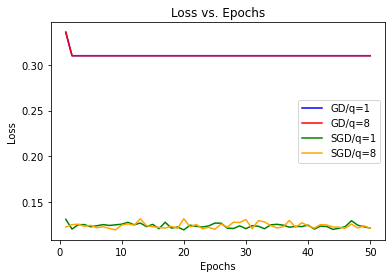

In [134]:
epochs = list(range(1, 51)) # 50 epochs

fig = plt.figure(figsize=(6,4))

line0 = plt.plot(epochs, obj_gd_q1, 'b', label='GD/q=1')
line1 = plt.plot(epochs, obj_gd_q8, 'r', label='GD/q=8')
line2 = plt.plot(epochs, obj_sgd_q1, 'g', label='SGD/q=1')
line3 = plt.plot(epochs, obj_sgd_q8, 'orange', label='SGD/q=8')

plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks()
plt.yticks()
plt.legend()
plt.show()

## 3.2 Loss vs. Communications

(Calculated based on the Server performing **two** communications per epoch) 

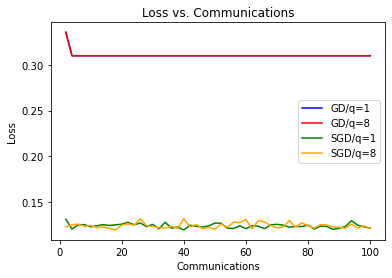

In [135]:
communications = [c*2 for c in list(range(1, 51))] # 50 epochs * 2 communications per epoch

fig = plt.figure(figsize=(6,4))

line0 = plt.plot(communications, obj_gd_q1, 'b', label='GD/q=1')
line1 = plt.plot(communications, obj_gd_q8, 'r', label='GD/q=8')
line2 = plt.plot(communications, obj_sgd_q1, 'g', label='SGD/q=1')
line3 = plt.plot(communications, obj_sgd_q8, 'orange', label='SGD/q=8')

plt.title('Loss vs. Communications')
plt.xlabel('Communications')
plt.ylabel('Loss')
plt.xticks()
plt.yticks()
plt.legend()
plt.show()